# Utilisation de Geopandas

Pour s'entrainer, on utilise le dataset airbnb de New York disponible sur kaggle. Il contient les données de géolocalisation des locations airbnb de New York.

## Afficher des points sur une carte

In [1]:
import pandas as pd
data = pd.read_csv("AB_NYC_2019.csv")

In [2]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48895 entries, 0 to 48894
Data columns (total 16 columns):
id                                48895 non-null int64
name                              48879 non-null object
host_id                           48895 non-null int64
host_name                         48874 non-null object
neighbourhood_group               48895 non-null object
neighbourhood                     48895 non-null object
latitude                          48895 non-null float64
longitude                         48895 non-null float64
room_type                         48895 non-null object
price                             48895 non-null int64
minimum_nights                    48895 non-null int64
number_of_reviews                 48895 non-null int64
last_review                       38843 non-null object
reviews_per_month                 38843 non-null float64
calculated_host_listings_count    48895 non-null int64
availability_365                  48895 non-null int64

On a bien les données de géolocalisation espérées (latitude, longitude). On va transformer ces informations en coordonnées puis en objet de type Point.

In [3]:
from shapely.geometry import Point
data['Coordinates'] = list(zip(data.longitude, data.latitude))
data['Coordinates'] = data['Coordinates'].apply(Point)

Avec cette information, on peut créer note GeoDataFrame

In [4]:
import geopandas as gpd
locations = gpd.GeoDataFrame(data, geometry='Coordinates')

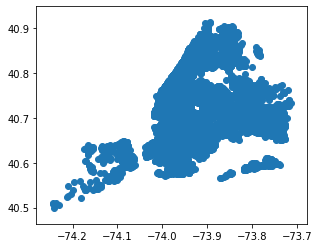

In [5]:
import matplotlib.pyplot as plt
%matplotlib inline

locations.plot()

On a bien récupéré une liste de point (très dense), mais sans une carte à mettre en fond, cela n'est pas terrible. On peut récupérer sur le site NYCOpenData, des cartes des borough de New York au format shapefile (attention, il faut les 4 fichiers shp, shx, dbf, prj pour avoir toutes les infos).

In [6]:
borough_limits = gpd.read_file('geo_export_8b63b8b6-860e-4a4d-b13b-9e060e8bfd24.shp')

In [7]:
borough_limits.columns

Index(['boro_code', 'boro_name', 'shape_area', 'shape_leng', 'geometry'], dtype='object')

Affichons la carte, uniquement avec les frontières.

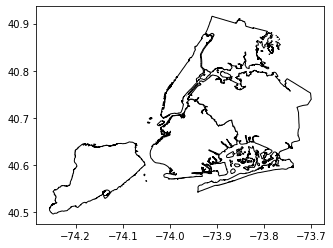

In [8]:
borough_limits.plot(color='white' , edgecolor='black')

Affichons la carte, avec une couleur par borough.

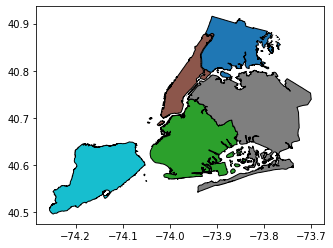

In [9]:
borough_limits.plot(column = 'boro_name' , edgecolor='black')

Il ne reste plus qu'à superposer les 2 cartes (et à indiquer les points de différentes façons suivant le type de location)

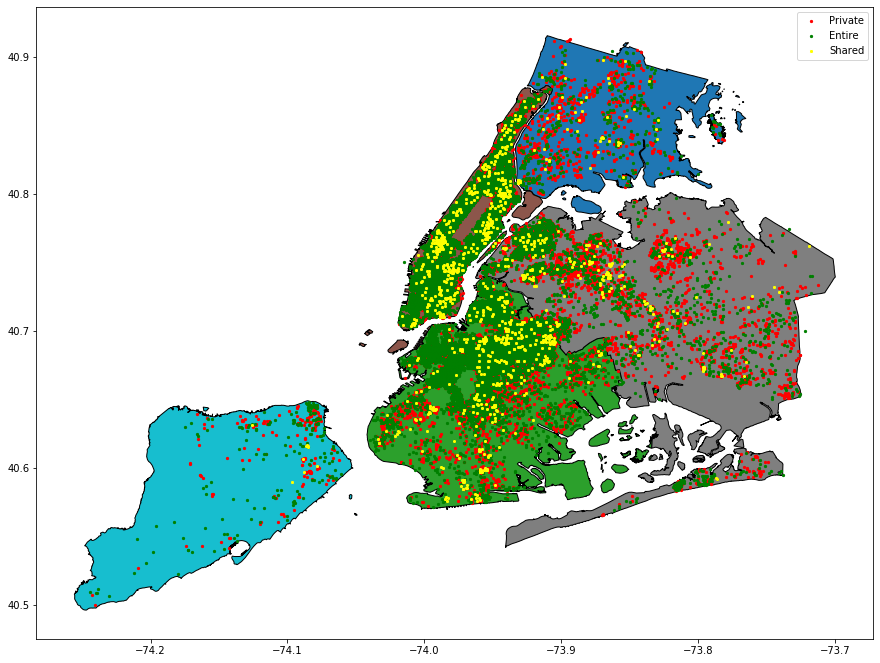

In [10]:
fig, ax = plt.subplots(figsize=(15,15))
borough_limits.plot(ax = ax, edgecolor='black', column = 'boro_name')
locations[locations['room_type'] == 'Private room'].plot(ax = ax, markersize=5,color='red', label = 'Private')
locations[locations['room_type'] == 'Entire home/apt'].plot(ax = ax, markersize=5,color='green', label = 'Entire')
locations[locations['room_type'] == 'Shared room'].plot(ax = ax, markersize=5,color='yellow', marker = "x", label = 'Shared')
plt.legend()

Même si la carte n'est pas très lisible en raison du très grand nombre de points, on a bien la résultat espéré.

## Afficher une carte colorée

Poussons plus loin pour afficher la moyenne des prix par borough.

In [11]:
data['neighbourhood_group'].unique()

array(['Brooklyn', 'Manhattan', 'Queens', 'Staten Island', 'Bronx'],
      dtype=object)

In [12]:
borough_limits['boro_name'].unique()

array(['Bronx', 'Staten Island', 'Brooklyn', 'Queens', 'Manhattan'],
      dtype=object)

Les 2 datasets ont bien une colonne qui va nous permettre de faire la jointure. Pour simplifier, on va réindexer borough_limits par les noms :

In [13]:
borough_limits_reindexed = borough_limits.set_index('boro_name')

On crée le tableau des prix moyens par quartier, puis on fait la jointure :

In [14]:
prix_moyen = data.groupby('neighbourhood_group')['price'].mean()
borough_limits_reindexed['prix_moyen'] = prix_moyen

On peut maintenant afficher la carte avec le prix moyen comme code couleur :

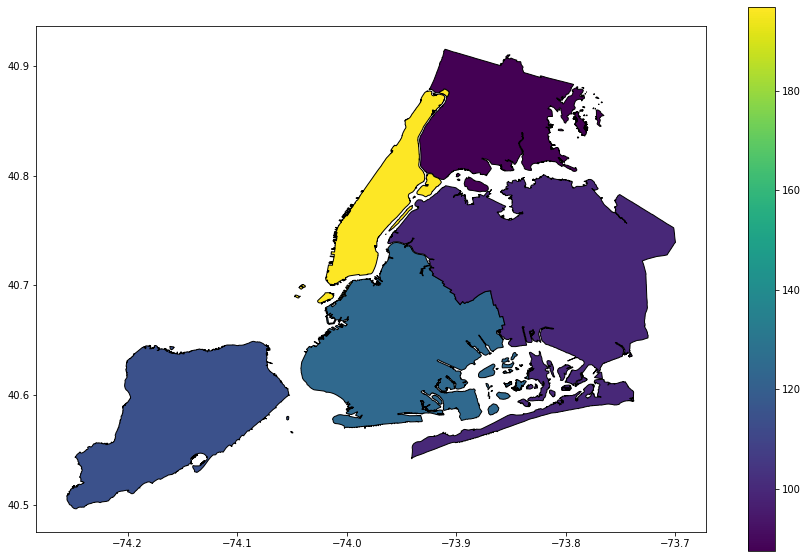

In [15]:
fig, ax = plt.subplots(figsize=(15,10))
borough_limits_reindexed.plot(ax = ax, edgecolor='black', column = 'prix_moyen', legend=True)

On a bien le résultat espéré, on voudrait faire une carte plus précise maintenant.